In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io.gtfs_reader import importer
from quetzal.io.gtfs_reader import frequencies as freq
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Preparation of the transport network.
## Saves a StepModel with bus service links and nodes from gtfs feeds.

In [3]:
input_path = '../input_static/public_transport/'
output_path = '../input_static/'
model_path = '../model/'

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [7]:
sm = stepmodel.read_json(model_path + 'ber_zones')

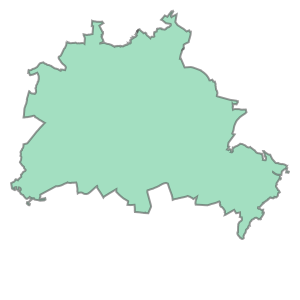

In [8]:
# Get the reference geometric hull
sm.zones = gpd.GeoDataFrame(sm.zones)
hull = sm.zones["geometry"].buffer(1e-3).unary_union
hull

In [9]:
# Add bus to the route types
route_type = 'bus'
sm.pt_route_types = [route_type]
prefix = route_type + '_'

In [10]:
# Start clean
sm.links = gpd.GeoDataFrame({'geometry' : []})
sm.links.crs = sm.epsg
sm.nodes = gpd.GeoDataFrame({'geometry' : []})
sm.nodes.crs = sm.epsg

In [11]:
# These tables hold side-information
sm.agencies = pd.DataFrame({'agency_id' : []})
sm.pt_routes = pd.DataFrame({'route_id' : []})

## Add bus transport

In [12]:
# With this function, we can restrict a feed spatially
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    #f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    #f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [13]:
def build_network(feed, prefix, hull):
    # Restrict the feed to a given date in order to analyse a
    # typical work day and not the whole week
    date = str(params['network_preparation']['feed_date'])
    # The dates must be within the feed start and end dates
    if not date in feed.calendar_dates['date']:
        date = feed.calendar_dates['date'].min()
    feed = feed.restrict(dates=[date, ])

    # Restrict to core hours
    time_range = [t.strip() for t in params['network_preparation']['feed_time_range'].split(',')]
    feed = feed.restrict(time_range=time_range)

    # Give the hourly restricted feed to the spatial restriction
    feed = spatial_restrict(feed, polygon=hull, how='inner')

    # Transform it into a graph
    feed.group_services()
    #feed.build_stop_clusters(distance_threshold=300) # clusterise stops
    feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
    # We could use the following quetzal-function, but this results into
    # a pandas-internal error due to the large dataset and  the replace function
    #feed_freq = feed.convert_to_frequencies(time_range=time_range)
    
    # Thus, we do it manually and use map instead of replace:
    pattern_column = 'pattern_id'
    # Compute pattern headway
    pattern_headways = freq.compute_pattern_headways(feed, time_range, pattern_column)
    # One trip per pattern
    feed.trips = feed.trips.groupby(pattern_column, as_index=False).first()
    to_replace_first = feed.trips.set_index('trip_id')[pattern_column].to_dict()
    feed.trips['trip_id'] = feed.trips['trip_id'].map(to_replace_first)
    feed.stop_times['trip_id'] = feed.stop_times['trip_id'].map(to_replace_first)
    # Replace frequencies
    frequencies = pattern_headways.reset_index().rename(columns={pattern_column: 'trip_id'})
    frequencies['start_time'] = time_range[0]
    frequencies['end_time'] = time_range[1]
    feed.frequencies = frequencies
    # Clean
    feed_freq = feed.restrict_to_trips(feed.trips.trip_id).clean()
    

    # Build links and nodes now from the frequency graph
    feed_freq.build_links_and_nodes()
    feed_freq.build_geometries(use_utm=False)

    # Reindex and set links index to trip_id
    feed_freq.links['trip_id'] = prefix + feed_freq.links['trip_id'].apply(str)
    feed_freq.links.index = [prefix + str(i) for i in range(len(feed_freq.links.index))]

    # Reindex stop_id (with it a and b in links)
    feed_freq.nodes['stop_id'] = prefix + 'n_' + feed_freq.nodes['stop_id'].apply(str)
    feed_freq.links['a'] = prefix + 'n_' + feed_freq.links['a'].apply(str)
    feed_freq.links['b'] = prefix + 'n_' + feed_freq.links['b'].apply(str)
    feed_freq.nodes.set_index('stop_id', drop=True, inplace=True)

    # Add route type to links and nodes
    mapping = {0:'tram', 1:'subway', 2:'rail_short', 3:'bus',
               4:'ferry', 5:'cablecar', 6:'gondola', 7:'funicular'}
    feed_freq.links['route_type'] = list(feed_freq.links.merge(
        feed_freq.routes, on='route_id')['route_type'].map(mapping))
    #links['route_type'] = route_type
    feed_freq.nodes['route_type'] = route_type

    # Reindex route_id and agency_id
    feed_freq.links['route_id'] = prefix + feed_freq.links['route_id'].apply(str)
    feed_freq.routes['route_id'] = prefix + feed_freq.routes['route_id'].apply(str)
    feed_freq.routes['agency_id'] = prefix + feed_freq.routes['agency_id'].apply(str)
    feed_freq.agency['agency_id'] = prefix + feed_freq.agency['agency_id'].apply(str)
    feed_freq.routes.set_index('route_id', drop=True, inplace=True)
    feed_freq.agency.set_index('agency_id', drop=True, inplace=True)

    # Add links and nodes to stepmodel
    sm.links = pd.concat([sm.links, feed_freq.links[
        ['route_id', 'route_type', 'a', 'b', 'time', 'geometry',
         'trip_id', 'link_sequence', 'headway']]])
    sm.nodes = pd.concat([sm.nodes, feed_freq.nodes[
        ['geometry', 'stop_name', 'route_type']]])
    # Add other
    sm.agencies = pd.concat([sm.agencies, feed_freq.agency])
    sm.pt_routes = pd.concat([sm.pt_routes, feed_freq.routes])

In [14]:
# Load feed
feed = importer.GtfsImporter(path=input_path + 'bus.zip', dist_units='m')
feed.describe()

MissingSchema: Invalid URL '../input_static/public_transport/bus.zip': No schema supplied. Perhaps you meant http://../input_static/public_transport/bus.zip?

In [13]:
# Build the network and merge into the model
feed.stops['parent_station'] = 0
feed.trips['shape_id'] = 0
build_network(feed, prefix, hull)

In [ ]:
# Fix the network integrity
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

In [ ]:
sm.links.sample(3)

In [ ]:
# Waiting time distribution in minutes
(sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [ ]:
sm.nodes.shape

In [ ]:
sm.links.shape

In [ ]:
sm.pt_routes.shape

In [ ]:
len(sm.links['route_id'].unique())

### Add missing zones
The GTFS feed above lacks bus service for the following NUTS3 zones: Celle, Altmarkkreis Salzwedel, Schaumburg, Harz, Mansfeld-Südharz, Schaumburg, Vorpommern-Greifswald, Ennepe-Ruhr-Kreis, Olpe, Siegen-Wittgestein, Altenkirchen (Westerwald), Westerwaldkreis, Ahrweiler, Neuwied, Maven-Koblenz, Koblenz, Rhein-Hunsrück-Kreis, Tuttlingen, Pfaffenhofen a.d. Ilm, Mühldorf a. Inn, Rottal-Inn, Sonneberg, Greiz, Miltenberg, Hof Landkreis

A complete GTFS feed from November 2020 contains most of these zones.

In [ ]:
# Filter for missing nodes only
missing = ['DE24D', 'DEG0L', 'DEG02', 'DEG0P', 'DEG0N', 'DEA58',
           'DEA59', 'DEB11', 'DEB12', 'DEB13', 'DEB17', 'DEB18',
           'DEB1A', 'DEB1B', 'DEB1C', 'DEB1D', 'DEE09', 'DEE0A',
           'DE928', 'DE923', 'DE931', 'DEE04', 'DE80N']
missing_zones = gpd.GeoDataFrame(sm.zones.loc[missing], crs=sm.epsg)
hull = missing_zones['geometry'].unary_union

In [ ]:
missing_zones['geometry'].plot()

In [ ]:
# Load feed and build the network
feed = importer.GtfsImporter(path=input_path + 'bus_2.zip', dist_units='m')
feed.stops['parent_station'] = 0
feed.trips['shape_id'] = 0
prefix = prefix + 'x_'
build_network(feed, prefix, hull)

In [ ]:
sm.nodes.plot(markersize=.5)

In [ ]:
# route types
sm.links['route_type'].unique()

In [ ]:
sm.links.loc[sm.links['route_type']=='subway'].plot()

## Save model

In [ ]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

In [ ]:
# Saving model...
sm.to_json(output_path + 'de_pt_network_bus',
          only_attributes=['zones', 'links', 'nodes',
                           'pt_route_types', 'agencies',
                           'pt_routes'],
           encoding='utf-8')

In [ ]:
sm.links.loc[sm.links['time']==0].plot(figsize=(16,16))

In [ ]:
len(sm.links.loc[sm.links['time']==0])